# D2W 2D Project Task 1

<div class="alert alert-block alert-info">

**Contents**

- [Group Members](#Group-Members)  
- [Introduction](#Introduction)
- [Key Files](#Key-Files)
- [Importing Data](#Importing-Data)
- [Data Processing](#Data-Processing)
- [Data Cleaning](#Data-Cleaning)
- [Train Model](#Train-Model)
- [Model Training Logs](#Model-Training-Logs)
- [Evaluate Model](#Evaluate-Model)

</div>

## Group Members 

[Return to top](#D2W-2D-Project-Task-1)  

| Name | ID | Contribution |
| :-: | :-: | :-: |
| Dickson Neo Jia Xuan | 1005203 | Sourcing of data |
| Wang Siyang | 1005485 | Pre-process data, Train model  and evaluate model |
| Fu Meihui | 1004864 | Data visualization |
| James Huang Yong Heng | 1005461 | Sourcing of data |
| Yeo Wan Li | 1005321 | Data visualization |

## Introduction

[Return to top](#D2W-2D-Project-Task-1)  

**Background**: It has been almost two years since COVID-19 first apeared, but there is still no end in sight yet. In a bid to control the pandemic, many governments have turned to data science to predict key statistics. One such statistic is the number of daily COVID-19 deaths.  

By predicting the number of deaths due to COVID-19, the government can better estimate the severity of the pandemic. Globally, as the pandemic becomes endemic and with the appearance of different variants of the virus, being able to predict the daily death toll will help governments to understand how lethal the virus at present.

**Problem Statement**: Predict the number of new deaths in various countries due to COVID-19.     

**Method**: Train Multiple Linear Regression Model with three features(new cases, hospital patients, icu patients) through gradient descent algorithm

## Key Files

[Return to top](#D2W-2D-Project-Task-1)

Below is the directory tree that shows the location of dataset and model (jupyter notebook)

```
task_1
├── Task 1-Final.ipynb
└── owid-covid-data.csv
```

These files have the following specifications:
- `Task 1-Final.ipynb` - contains the code needed to extract data, build model and predict results
- `owid-covid-data.csv` - database of each country's COVID-related data in each day. Data is downloaded from
[Our World in Data (OWID)](https://github.com/owid/covid-19-data/tree/master/public/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Data 

[Return to top](#D2W-2D-Project-Task-1)

**Choice of dataset**: Dataset from OWID contains daily data of each country across the world. Hence, there is a large number of data to work with initially (125760 rows, 61 features), making it more likely that there will be sufficient data to train the Linear Regression Model to a high accuracy.

**Data Cleaning**: However, with that much data, checks to remove illogical data points is necessary. For example, rows with NaN values in selected features are removed. Sections with regional data (e.g. aggregate data for continents) are removed too. Sanity checks, such as a positive number of COVID-19 deaths and checking that there are more deaths than cases are carried out.

In [2]:
##import dataset
df = pd.read_csv("owid-covid-data.csv")

In [3]:
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,ZWE,Africa,Zimbabwe,2021-10-19,132405.0,37.0,55.571,4659.0,1.0,2.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125755,ZWE,Africa,Zimbabwe,2021-10-20,132437.0,32.0,47.000,4659.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125756,ZWE,Africa,Zimbabwe,2021-10-21,132540.0,103.0,41.286,4662.0,3.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125757,ZWE,Africa,Zimbabwe,2021-10-22,132588.0,48.0,43.286,4663.0,1.0,1.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
##clean data
#feature_names = ['hosp_patients','icu_patients']
feature_names = ['new_cases_smoothed','hosp_patients','icu_patients']
target_name = ['new_deaths_smoothed']
country_info = ['iso_code','continent','location','date']

##copy data over into new dataframe
clean_df = df.loc[:,country_info].copy()

##create new feature columns
for shifted_feature in feature_names:
    clean_df[shifted_feature] = 0
#     clean_df[shifted_feature + '_shifted'] = 0


##shift data for each column in feature_name downward by 19 days
##since there is a 17-21 day lag between infection and death
def shift_column(df,clean_df,feature_names,shift_val):
    for location in set(df['location'].values):
        for i in range(len(feature_names)):
            feature = feature_names[i]
#             feature_shifted = feature + '_shifted'

            copied_column = df[df['location'] == location][feature]
            shifted_data = copied_column.shift(periods = shift_val, fill_value = 0)

            row_indexes = clean_df[clean_df['location'] == location].index
            clean_df.loc[row_indexes,feature] = shifted_data
    return clean_df

#clean_df = shift_column(df,clean_df,feature_names[0:2],19)
clean_df = shift_column(df,clean_df,feature_names,0)
#clean_df = shift_column(df,clean_df,[feature_names[2]],19)

##copy target column
clean_df[target_name] = df[target_name]

##remove continents
continents = ['Africa','Asia','Europe','European Union','North America','South America','Oceania','World']
clean_df = clean_df.loc[~clean_df['location'].isin(continents)]
clean_df

,iso_code,continent,location,date,new_cases_smoothed,hosp_patients,icu_patients,new_deaths_smoothed
0,AFG,Asia,Afghanistan,2020-02-24,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
125754,ZWE,Africa,Zimbabwe,2021-10-19,55.571,NaN,NaN,2.000
125755,ZWE,Africa,Zimbabwe,2021-10-20,47.000,NaN,NaN,1.571
125756,ZWE,Africa,Zimbabwe,2021-10-21,41.286,NaN,NaN,1.000
125757,ZWE,Africa,Zimbabwe,2021-10-22,43.286,NaN,NaN,1.143


In [5]:
##remove NaN in features
for feature in feature_names:
#     feature += '_shifted'
    print(feature)
    clean_df = clean_df[clean_df[feature].notna()]

clean_df

new_cases_smoothed
hosp_patients
icu_patients


,iso_code,continent,location,date,new_cases_smoothed,hosp_patients,icu_patients,new_deaths_smoothed
7255,AUT,Europe,Austria,2020-04-01,731.857,856.0,215.0,16.571
7256,AUT,Europe,Austria,2020-04-02,602.857,823.0,219.0,15.571
7257,AUT,Europe,Austria,2020-04-03,552.429,829.0,245.0,15.714
7258,AUT,Europe,Austria,2020-04-04,501.429,826.0,245.0,16.857
7259,AUT,Europe,Austria,2020-04-05,466.143,712.0,244.0,16.857
...,...,...,...,...,...,...,...,...
119820,USA,North America,United States,2021-10-18,84932.143,51686.0,16451.0,1662.571
119821,USA,North America,United States,2021-10-19,81350.714,50571.0,16275.0,1675.000
119822,USA,North America,United States,2021-10-20,76678.286,49331.0,15981.0,1672.714
119823,USA,North America,United States,2021-10-21,75823.571,48579.0,15678.0,1653.143


In [6]:
##target: new_deaths_smoothed
clean_df = clean_df[clean_df[target_name[0]].notna()]
clean_df = clean_df[clean_df[target_name[0]]>=0]
clean_df

,iso_code,continent,location,date,new_cases_smoothed,hosp_patients,icu_patients,new_deaths_smoothed
7255,AUT,Europe,Austria,2020-04-01,731.857,856.0,215.0,16.571
7256,AUT,Europe,Austria,2020-04-02,602.857,823.0,219.0,15.571
7257,AUT,Europe,Austria,2020-04-03,552.429,829.0,245.0,15.714
7258,AUT,Europe,Austria,2020-04-04,501.429,826.0,245.0,16.857
7259,AUT,Europe,Austria,2020-04-05,466.143,712.0,244.0,16.857
...,...,...,...,...,...,...,...,...
119820,USA,North America,United States,2021-10-18,84932.143,51686.0,16451.0,1662.571
119821,USA,North America,United States,2021-10-19,81350.714,50571.0,16275.0,1675.000
119822,USA,North America,United States,2021-10-20,76678.286,49331.0,15981.0,1672.714
119823,USA,North America,United States,2021-10-21,75823.571,48579.0,15678.0,1653.143


In [7]:
##remove the case where new_deaths is larger than number of cases
# clean_df = clean_df[clean_df['new_cases_smoothed_shifted'] > clean_df[target_name[0]]]
clean_df = clean_df[clean_df['new_cases_smoothed'] > clean_df[target_name[0]]]
clean_df

,iso_code,continent,location,date,new_cases_smoothed,hosp_patients,icu_patients,new_deaths_smoothed
7255,AUT,Europe,Austria,2020-04-01,731.857,856.0,215.0,16.571
7256,AUT,Europe,Austria,2020-04-02,602.857,823.0,219.0,15.571
7257,AUT,Europe,Austria,2020-04-03,552.429,829.0,245.0,15.714
7258,AUT,Europe,Austria,2020-04-04,501.429,826.0,245.0,16.857
7259,AUT,Europe,Austria,2020-04-05,466.143,712.0,244.0,16.857
...,...,...,...,...,...,...,...,...
119820,USA,North America,United States,2021-10-18,84932.143,51686.0,16451.0,1662.571
119821,USA,North America,United States,2021-10-19,81350.714,50571.0,16275.0,1675.000
119822,USA,North America,United States,2021-10-20,76678.286,49331.0,15981.0,1672.714
119823,USA,North America,United States,2021-10-21,75823.571,48579.0,15678.0,1653.143


In [490]:
df = clean_df.iloc[:,4:]
clean_df

,iso_code,continent,location,date,new_cases_smoothed,hosp_patients,icu_patients,new_deaths_smoothed


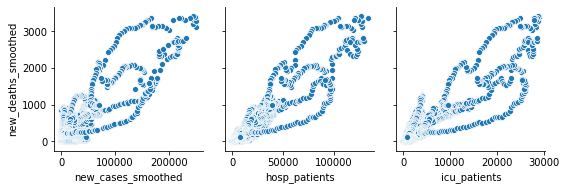

In [8]:
#country_df = test.loc[test['location'] == 'United States']
features = ['new_cases_smoothed','hosp_patients','icu_patients']
for i in range(0,len(features),5):
    myplot=sns.pairplot(data = clean_df,
                        y_vars=['new_deaths_smoothed'],
                        x_vars=features[i:i+5])

In [477]:
clean_df.to_excel(r'C:\Users\Siyang\OneDrive - Singapore University of Technology and Design\Freshmore Term 3\2D Project\MU Component\shift_19_3_feature_15.xlsx')

In [455]:
##split data into train and test set
def get_features_targets(df,feature_names,target_name):
    ###
    ### YOUR CODE HERE
    df_feature = df.loc[:,feature_names]
    df_target = pd.DataFrame(df.loc[:,target_name])
    return df_feature, df_target

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    n = df_feature.shape[0]
    size = int(n*test_size)
    
    test_idx = np.random.choice(n, size,replace = False)
    df_feature_test = pd.DataFrame(df_feature.iloc[test_idx])
    df_target_test = pd.DataFrame(df_target.iloc[test_idx])

    train_idx = list(set(i for i in range(n)) - set(test_idx))
    df_feature_train = pd.DataFrame(df_feature.iloc[train_idx])
    df_target_train = pd.DataFrame(df_target.iloc[train_idx])
    return df_feature_train, df_feature_test, df_target_train, df_target_test

feature_names = df.columns[:-1]
df_features, df_target = get_features_targets(df,feature_names,target_name)
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,100,0.3)

## Train Model

[Return to top](#D2W-2D-Project-Task-1)

Introduce the Multiple Linear Regression model  
Explain why it is suitable

In [456]:
##helper functions for preparing data for insertion into model
def normalize_z(df):
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    #carry out the normalization procedure
    dfout = (df - mean)/std
    #display(dfout)
    return dfout

def prepare_features(df_feature):
    df_feature = normalize_z(df_feature)
    m = df_feature.shape[0]
    first_column = np.ones(m).reshape(m,1)
    x_matrix = np.concatenate((first_column,df_feature),1)
    return x_matrix

def prepare_target(df_target):
    return df_target.to_numpy()

In [457]:
##set up cost function
def compute_cost(X, y, beta):
    J = 0
    hypothesis  = np.matmul(X,beta)
    error = hypothesis - y
    m = y.shape[0]
    J = (1/(2*m)) * np.matmul(error.T,error)
    return J

##set up gradient descent
def gradient_descent(df, beta, alpha, num_iters):
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,100,0.3)
    
    X_train = prepare_features(df_features_train)
    y_train = prepare_target(df_target_train)
    X_test = prepare_features(df_features_test)
    y_test = prepare_target(df_target_test)
    
    m = y_train.shape[0]
    J_storage_train = np.zeros((num_iters,1))
    J_storage_test = np.zeros((num_iters,1))
    for i in range(num_iters):
        derivative = (1/m) * np.matmul(X_train.T, (np.matmul(X_train,beta)-y_train))
        beta = beta - alpha * derivative
        J_storage_train[i] = compute_cost(X_train,y_train,beta)
        J_storage_test[i] = compute_cost(X_test,y_test,beta)
    return beta, J_storage_train, J_storage_test

##optimize weights
n = len(df_features.columns)
iterations = 2000
alpha = 0.1
beta = np.zeros((n+1,1))

beta, J_storage_train, J_storage_test = gradient_descent(df, beta, alpha, iterations)

## Model Training Logs

[Return to top](#D2W-2D-Project-Task-1)

During training of data, it is shown that the cost of test and train datasets converge after ~100 iterations. Overfitting did not occur as the difference in cost between test and train dataset continued to be negligible.

Besides monitoring the cost function, we also kept a record of the cost function as we tweaked the features/target of the model.

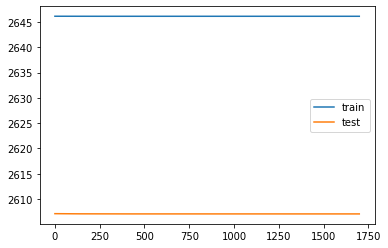

In [458]:
plt.plot(J_storage_train[300:])
plt.plot(J_storage_test[300:])
plt.legend(['train','test'])

In [459]:
#shift on all all countries
J_storage_train[-1][0]

2646.1168601604895

## Evaluate Model

[Return to top](#D2W-2D-Project-Task-1)

**Chosen Metric**: The (root of)the mean squared error was chosen as a metric in order to evaluate the accuracy of this model. The closer it is to 0, the more accurate it is.  

**Results**: The root mean squared error of the model is 83.3(3s.f). This shows that there is a error of 83.3 new deaths from the actual value.  

1. The rate of vaccinations not being accounted for in the model. <br>
Vaccinations result in milder Covid-19 symptoms and a lesser transmission rate within the community. This could have affected the trends in the selected features by decreasing the number of new confirmed Covid-19 cases(and hence ICU and hospital cases). The degree to which the features are affected could also be different between locations.
2. Locations with a great difference between gdp and population density was included in the dataset. <br>
This might have affected how Covid-19 affected the community there, such as the transmission rate of the virus. Low gdp might have affected the supply of public resources such as masks and disinfectants, which could increase the rate of transmission, and hence the feature 'new cases' would increase. Population densities also play a part in contributing to the transmission of the virus, where high population densities would result in the virus being transmitted more easily, and hence contributing to an increase in the feature 'new cases'.
3. Outliers in the dataset. <br>
There might be outliers in the dataset that caused the model to become biased. This is because each data point that the model takes in is considered on its own and not in relation with the previous data points. This causes the model to be vulnerable to outliers that can significantly affect the model.

In [466]:
##evaluate cost on test data
def predict(df_feature, beta):
    #df_feature = prepare_features(df_feature)
    df_feature = prepare_features(df_feature)
    pred_y = np.matmul(df_feature,beta)
    return pred_y

# pred = predict(df_features_test,beta)
pred = predict(df_features,beta)

In [467]:
## change predicted results into Dataframe form, so that can compare with original data
mod_pred = pd.DataFrame(pred, columns = ['predicted deaths'], index = df_target_test.index)

ValueError: Shape of passed values is (15639, 1), indices imply (4691, 1)

In [462]:
pd.concat([df_target_test,mod_pred],1)

,new_deaths_smoothed,predicted deaths
80135,17.571,73.142873
106445,121.571,200.432762
7349,0.714,-5.577061
40907,598.143,637.701956
40105,0.429,-5.066213
...,...,...
109041,20.429,32.137692
56307,2.286,0.203879
101897,97.571,44.293327
40629,0.143,-6.412406


Text(0, 0.5, 'new_deaths_smoothed')

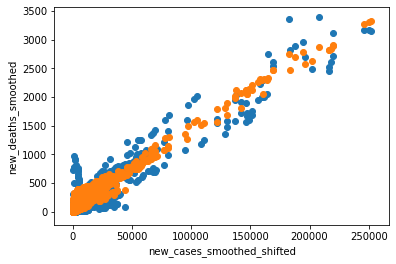

In [463]:
plt.scatter(df_features_test[feature_names[0]],df_target_test)
plt.scatter(df_features_test[feature_names[0]],pred)
plt.xlabel(feature_names[0])
plt.ylabel(target_name[0])

In [427]:
# plt.scatter(df_features_test[feature_names[1]],df_target_test)
# plt.scatter(df_features_test[feature_names[1]],pred)
# plt.xlabel(feature_names[1])
# plt.ylabel(target_name[0])

In [428]:
# plt.scatter(df_features_test[feature_names[2]],df_target_test)
# plt.scatter(df_features_test[feature_names[2]],pred)
# plt.xlabel(feature_names[2])
# plt.ylabel(target_name[0])

In [468]:
def r2_score(y, ypred):
    error_n = y - ypred
    numerator = np.matmul(error_n.T,error_n)[0][0]/y.shape[0]
    #print(numerator)
    error_d = y - np.full((y.shape[0],y.shape[1]),np.mean(y))
    denominator = np.matmul(error_d.T,error_d)[0][0]/y.shape[0]
    #print(denominator)
    
    return 1 - numerator/denominator


def mean_squared_error(target, pred):
    error = target - pred
    n = target.shape[0]
    return ((1/n) * np.matmul(error.T,error))[0][0]
    ###
    pass

In [470]:
# change target test set to a numpy array
# target = prepare_target(df_target_test)
target = prepare_target(df_target)

# Calculate r2 score by calling a function
r2 = r2_score(target,pred)
mse = mean_squared_error(target,pred)
print(r2)
print(mse)

0.9312379494520402
5259.2269461262285
